In [2]:
import numpy as np
import procgen_tools
import matplotlib.pyplot as plt
from procgen_tools.imports import *
from procgen_tools import visualization, maze, vfield, patch_utils


In [ ]:
CHEESE = 2
EMPTY = 100
BLOCKED = 51
MOUSE = 25  # UNOFFICIAL. The mouse isn't in the grid in procgen.

def visualize_maze(state: maze.EnvState) -> None:
    venv = maze.venv_from_grid(state.inner_grid())
    visualization.visualize_venv(venv, render_padding=False)


In [ ]:
# Generate empty maze
maze_dim = 9
grid_empty = np.ones((maze_dim,maze_dim))*EMPTY
venv_empty = maze.venv_from_grid(grid_empty)
#visualize_maze(maze.state_from_venv(venv))

# Generate maze with cheese in location x, y
x=3 
y=3
grid_cheese = np.ones((maze_dim,maze_dim))*EMPTY
grid_cheese[x,y] = CHEESE
venv_cheese = maze.venv_from_grid(grid_cheese)
#visualize_maze(maze.state_from_venv(venv_cheese))



In [ ]:
# Load models:
policy1, hook1 = load_model('15', 15)
policy2, hook2 = load_model('1', 15)
AX_SIZE = 2

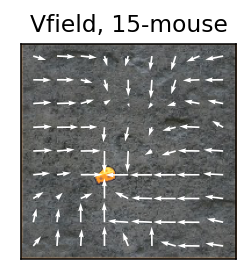

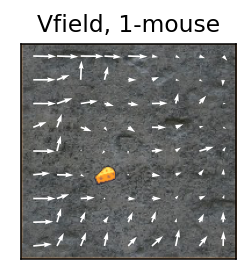

In [ ]:
seed = 0

def compare_component_probabilities(venv = venv_empty, seed=seed, hook_0=hook, name='Model'):
    fig, axs = plt.subplots(1, 1, figsize=(AX_SIZE, AX_SIZE))
    vf = vfield.vector_field(venv, policy=hook_0.network)

    
    vfield.plot_vf(vf, ax=axs, show_components=False)
    axs.set_title('Vfield, {}-mouse'.format(name))

venv_test = venv_cheese
compare_component_probabilities(venv_test, seed, hook1, "15")
compare_component_probabilities(venv_test, seed, hook2, "1")

In [ ]:
from procgen_tools.procgen_imports import *

class ActivationsPlotterColab:
    def __init__(self, labels: List[str], plotter: Callable, activ_gen: Callable, hook, coords_enabled: bool=False, defaults : dict = None, save_dir='experiments/visualizations', **act_kwargs):
        """
        labels: The labels of the layers to plot
        plotter: A function that takes a label, channel, and activations and plots them
        activ_gen: A function that takes a label and obs and returns the activations which should be sent to plotter 
        hook: The hook that contains the activations
        coords_enabled: Whether to enable the row and column sliders
        defaults: A dictionary of default values for the plotter, where the keys are attributes of this class which themselves have the "value" attribute. The class value will be set to the corresponding dictionary value.
        act_kwargs: Keyword arguments to pass to the activations generator
        """
        self.fig = go.Figure() 
        self.plotter = plotter
        self.activ_gen = activ_gen
        self.act_kwargs = act_kwargs
        self.hook = hook
        self.save_dir = save_dir

        # Remove the _out layer and "embedder." prefixes
        formatted_labels = format_labels(labels)
        self.label_widget = Dropdown(options=formatted_labels, value=formatted_labels[0], description="Layers")
        self.channel_slider = IntSlider(min=0, max=127, step=1, value=0, description="Channel")
        
        # Add channel increment and decrement buttons
        button_width = '10px'
        decrement_button, increment_button = [Button(description=descr_str, layout=Layout(width=button_width)) for descr_str in ("-", "+")]
        def add_to_slider(x : int):
            # Clip the value to the min and max
            self.channel_slider.value = np.clip(self.channel_slider.value + x, self.channel_slider.min, self.channel_slider.max)
            self.update_plotter()
        decrement_button.on_click(lambda _: add_to_slider(-1))
        increment_button.on_click(lambda _: add_to_slider(1))
        self.widgets = [self.fig, self.label_widget, HBox([self.channel_slider, decrement_button, increment_button])] # TODO make this a helper for converting arbitrary sliders

        # Add row and column sliders if enabled
        self.coords_enabled = coords_enabled
        if coords_enabled:
            self.col_slider, self.row_slider = (IntSlider(min=0, max=62, step=1, value=32, description="Column"), IntSlider(min=0, max=63, step=1, value=32, description="Row"))
            self.widgets.extend([self.col_slider, self.row_slider])

        # Add a custom filename widget
        self.filename_widget = Text(value="", placeholder="Custom filename", disabled=False)
        self.filename_widget.layout.width = '150px'
        self.button = Button(description="Save image")
        self.button.on_click(self.save_image)
        self.widgets.append(HBox([self.filename_widget, self.button]))

        # Set the default values for the plotter, if provided
        if defaults is not None:
            for key, value in defaults.items():
                getattr(self, key).value = value

        # Ensure that the plot is updated when the widgets are changed
        for widget in self.widgets:
            if widget != self.fig:
                widget.observe(self.update_plotter, names='value')
        
        # Set the initial plot
        self.update_plotter()

    def display(self):
        """ Display the elements; this function separates functionality from display. """
        display(self.fig)
        display(VBox(self.widgets[1:-1])) # Show a VBox of the label dropdown and the sliders, centered beneath the plot
        display(self.widgets[-1])

    def save_image(self, b): # Add a save button to save the image
        basename = self.filename_widget.value if self.filename_widget.value != "" else f"{self.label_widget.value}_{self.channel_slider.value}{f'_{self.col_slider.value}_{self.row_slider.value}' if self.coords_enabled else ''}"
        filepath = f"{self.save_dir}/{basename}.png" 

        # Annotate to the outside of the plot
        old_title = self.fig.layout.title
        self.fig.layout.title = f"{self.label_widget.value};\nchannel {self.channel_slider.value}{f' at ({self.col_slider.value}, {self.row_slider.value})' if self.coords_enabled else ''}"

        self.fig.update_yaxes(autorange="reversed") 
        self.fig.write_image(filepath)
        print(f"Saved image to {filepath}")

        self.fig.layout.title = old_title # Clear the title
        
        self.filename_widget.value = "" # Clear the filename_widget box

    def update_plotter(self, b=None):
        """ Update the plot with the current values of the widgets. """
        label = expand_label(self.label_widget.value)        
        self.channel_slider.max = models.num_channels(hook=self.hook, layer_name=label) - 1 
        channel = self.channel_slider.value = min(self.channel_slider.value, self.channel_slider.max)
        
        if self.coords_enabled:
            col, row = self.col_slider.value, self.row_slider.value
            activations = self.activ_gen(row, col, label, self.hook, **self.act_kwargs)
        else:
            activations = self.activ_gen(label, self.hook, **self.act_kwargs) # shape is (b, c, h, w) at conv layers, (b, activations) at linear layers 

        if len(activations.shape) == 2: # Linear layer (batch, hidden_dim)
            # Ensure shape[1] is a perfect square
            sqrt_act = int(math.sqrt(activations.shape[1]))
            if sqrt_act * sqrt_act == activations.shape[1]:
                activations = np.reshape(activations, newshape=(activations.shape[0], 1, sqrt_act, sqrt_act)) # Make a dummy channel dimension
                # Annotate that there is no spatial meaning to the activations
                self.fig.update_layout(title_text=f"{self.label_widget.value}; reshaped to 2D; no spatial meaning")
            else:
                activations = np.expand_dims(activations, axis=(1,2)) # Add a dummy dimension to the activations

        self.plotter(activations=activations[:, channel], fig=self.fig) # Plot the activations
        format_plotter(fig=self.fig, activations=activations, is_policy_out=self.label_widget.value == 'fc_policy_out', title=self.label_widget.value)

In [ ]:
SEED = 0
venv = maze.create_venv(num=1, start_level=SEED, num_levels=1) 

widget_box = visualization.custom_vfield(policy1, venv=venv, show_components=True) 
display(widget_box)

Box(children=(HBox(children=(GridspecLayout(children=(Button(layout=Layout(grid_area='widget001', height='0px'…

In [ ]:

settings = {'channel_slider': 5, 'label_widget': 'block2.res1.resadd_out'}

custom_maze_plotter = ActivationsPlotterColab(labels, lambda activations, fig: plot_activations(activations[0], fig=fig), patch_utils.values_from_venv, hook, defaults=settings, venv=venv)
custom_maze_plotter.display() 

NameError: name 'ActivationsPlotterColab' is not defined